<a href="https://colab.research.google.com/github/khoanguyenvietmanh/InfoGAN/blob/main/InfoGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%matplotlib inline
%tensorflow_version 1.x
from tqdm import tqdm_notebook
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential,Model,layers,losses,optimizers,backend,activations,Input
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.initializers import RandomNormal
from google.colab.patches import cv2_imshow
from math import ceil
import tensorflow_probability as tfp

TensorFlow 1.x selected.


In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
tf.enable_eager_execution()

In [ ]:
!pip install unrar

In [ ]:
!unrar x '/content/gdrive/MyDrive/InfoGAN/chair_dataset_new.rar'

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Extracting  chair_dataset_new/chair_928_render_3.png                      91%  OK 
Extracting  chair_dataset_new/chair_928_render_30.png                     91%  OK 
Extracting  chair_dataset_new/chair_928_render_31.png                     91%  OK 
Extracting  chair_dataset_new/chair_928_render_32.png                     91%  OK 
Extracting  chair_dataset_new/chair_928_render_33.png                     91%  OK 
Extracting  chair_dataset_new/chair_928_render_34.png                     91%  OK 
Extracting  chair_dataset_new/chair_928_render_35.png                     91%  OK 
Extracting  chair_dataset_new/chair_928_render_36.png                     91%  OK 
Extracting  chair_dataset_new/chair_928_render_37.png                     91%  OK 
Extracting  chair_dataset_new/chair_928_render_38.png                     91%  OK 
Extracting  chair_datas

In [ ]:
def create_chair_dataset(path):
  dataset = []
  for i, file_image in enumerate(os.listdir(path)):
    image = cv2.imread(path + '/' + file_image)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    dataset.append(image)

  dataset = np.asarray(dataset, dtype=np.uint8)

  batch, height, width = dataset.shape

  dataset = np.reshape(dataset, (batch, height, width, 1))

  return dataset

In [ ]:
def MiniBatch_Discrimination(features, numFeatures, kernels, kernelDim=5):

  T = tf.get_variable(name="T", shape=(numFeatures, kernels, kernelDim), initializer=tf.truncated_normal_initializer(stddev=0.1))
  
  T = tf.reshape(T, shape=(-1, kernels * kernelDim))

  M = tf.matmul(features, T)

  M = tf.reshape(M, shape=(-1, kernels, kernelDim))

  M_expand_dims = tf.expand_dims(M, axis=1)

  M_diff = tf.math.exp(-tf.reduce_sum(tf.abs(M_expand_dims - M), axis=3))

  output = tf.reduce_sum(M_diff , axis=1)

  return tf.concat([features, output], axis=1)

In [ ]:
class Dataset:
    def __init__(self, bacth_size, is_preprocessing=True):
        self.dataset = create_chair_dataset('/content/chair_dataset_new')

        self.dataset = np.asarray(self.dataset, dtype=np.float32)

        self.dataset = self.dataset[:50000]

        if is_preprocessing:
          self.preprocessing_image()

        self.batch_size = bacth_size
        
        self.batch_id = 0

    def preprocessing_image(self):
        self.dataset = 2 * (self.dataset / 255) - 1

    def next_batch(self):
        start = self.batch_id * self.batch_size
        end = start + self.batch_size

        self.batch_id += 1

        if end > self.dataset.shape[0]:
            end = self.dataset.shape[0]

            self.batch_id = 0

            list_indices = list(range(self.dataset.shape[0]))

            np.random.seed(2020)

            np.random.shuffle(list_indices)

        return self.dataset[start:end]

In [ ]:
def Generate_noise_and_latent_code(batch_size, latent_dim, size_discrete_code, num_discrete_code, num_continuous_code, check_ret=False):
      random_latent_vector = tf.random.uniform(shape=[batch_size, latent_dim], minval=-1, maxval=1)

      random_code_number = np.random.multinomial(1, [1/num_discrete_code] * num_discrete_code, batch_size)

      for i in range(size_discrete_code - 1):
        temp = np.random.multinomial(1, [1/num_discrete_code] * num_discrete_code, batch_size)

        random_code_number = np.concatenate([random_code_number, temp], axis=1)

      random_code_semantic = tf.random.uniform(shape=(batch_size, num_continuous_code), minval=-1, maxval=1)

      random_vector_input = tf.concat([random_latent_vector,random_code_number,random_code_semantic], axis=1)

      if check_ret:
        return random_code_number, random_code_semantic, random_vector_input
      
      return random_vector_input

In [ ]:
def Discriminator(image_shape):
  inputs = Input(shape=image_shape)
  x = layers.Conv2D(filters=64, kernel_size=4, strides=2, padding="same", input_shape=image_shape, use_bias=False)(inputs)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Conv2D(filters=128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Conv2D(filters=256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Conv2D(filters=256, kernel_size=4, strides=1, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)
  x = layers.Conv2D(filters=256, kernel_size=4, strides=1, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(units=1024, use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)

  #outputs_D = MiniBatch_Discrimination(x, 1024, 100)
  outputs_D = layers.Dense(units=1, activation="sigmoid", use_bias=False)(x)

  D_model = Model(inputs=inputs, outputs=outputs_D, name="Discriminator")

  outputs_Q = layers.Dense(units=128, use_bias=False)(x)
  outputs_Q = layers.BatchNormalization()(outputs_Q)
  outputs_Q = layers.LeakyReLU(0.2)(outputs_Q)


  outputs_Q_1 = layers.Dense(units= 20, activation="softmax", use_bias=False)(outputs_Q)
  outputs_Q_2 = layers.Dense(units= 20, activation="softmax", use_bias=False)(outputs_Q)
  outputs_Q_3 = layers.Dense(units= 20, activation="softmax", use_bias=False)(outputs_Q)
  outputs_Q_mu_1 = layers.Dense(units=1, use_bias=False)(outputs_Q)
  outputs_Q_sigma_1 = layers.Dense(units=1, activation=lambda x: tf.math.exp(x), use_bias=False)(outputs_Q)
  #outputs_Q_mu_2 = layers.Dense(units=1)(outputs_Q)
  #outputs_Q_sigma_2 = layers.Dense(units=1, activation=lambda x: tf.math.exp(x))(outputs_Q)

  Q_model = Model(inputs=inputs, outputs=[outputs_Q_1, outputs_Q_2, outputs_Q_3, outputs_Q_mu_1, outputs_Q_sigma_1], name="Auxilliary")
  D_model.summary()

  Q_model.summary()

  return D_model, Q_model


In [ ]:
def Generator(latent_dim):
  model = Sequential([layers.Dense(units=1024, input_shape=(latent_dim, ), use_bias=False),
                      layers.BatchNormalization(),
                      layers.Activation(activation="relu"),
                      layers.Dense(units=8 * 8 * 256, use_bias=False),
                      layers.BatchNormalization(),
                      layers.Activation(activation="relu"),
                      layers.Reshape((8, 8, 256)),
                      layers.Conv2DTranspose(filters=256, kernel_size=4, strides=1, padding="same", use_bias=False),
                      layers.BatchNormalization(),
                      layers.Activation(activation="relu"),
                      layers.Conv2DTranspose(filters=256, kernel_size=4, strides=1, padding="same", use_bias=False),
                      layers.BatchNormalization(),
                      layers.Activation(activation="relu"),
                      layers.Conv2DTranspose(filters=128, kernel_size=4, strides=2, padding="same", use_bias=False),
                      layers.BatchNormalization(),
                      layers.Activation(activation="relu"),
                      layers.Conv2DTranspose(filters=64, kernel_size=4, strides=2, padding="same", use_bias=False),
                      layers.BatchNormalization(),
                      layers.Activation(activation="relu"),
                      layers.Conv2DTranspose(filters=1, kernel_size=4, strides=2, padding="same", use_bias=False),
                      layers.BatchNormalization(),
                      layers.Activation("tanh")], name="Generator")
  model.summary()
  return model

In [ ]:
def plot_image(generator, latent_dim, size_discrete_code, num_discrete_code, num_continuous_code):
  start_value = 2
  num_generate = 10

  c = [-2, -0.8, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 0.8, 2]
   
  noise = np.random.uniform(low=-1, high=1, size=[latent_dim])

  noise = np.array([noise for i in range(num_generate)], dtype=np.float32)

  image = []
  
  for k in range(num_generate):
    latent_code = np.zeros((num_generate, 61))
    latent_code[:, k] = 1
    latent_code[:, 20 + k] = 1
    latent_code[:, 40 + k] = 1

    #continuous code 1
    latent_code[:, size_discrete_code * num_discrete_code] = c
    generated = generator.predict(tf.concat([noise, latent_code], axis=1))

    image.append(generated)

    #continuos code 2
    #latent_code[:, num_discrete_code] = [0] * num_generate
    #latent_code[:, num_discrete_code + 1] = c

    generated = generator.predict(tf.concat([noise, latent_code], axis=1))
    image.append(generated)

  fig, axes = plt.subplots(20, num_generate, figsize=(num_generate, 20))
  fig.subplots_adjust(hspace=0.3, wspace=0.3)

  image = np.asarray(image)

  image = (image + 1) / 2. * 255.

  for i in range(20):
    for j in range(num_generate):
      axes[i][j].set_axis_off()
      axes[i][j].imshow(tf.squeeze(image[i][j]))
  
  plt.show()

In [ ]:
def plot_image_1(list_image):
    list_image = (list_image + 1) / 2. * 255.
    list_image = list_image.astype(np.uint8)
    for i in range(tf.shape(list_image)[0]):
        plt.subplot(2,5,i+1)
        plt.imshow(tf.squeeze(list_image[i]))
    plt.show()

In [ ]:
def training_2():
  cross_entropy = losses.BinaryCrossentropy()
  categorical_loss = losses.CategoricalCrossentropy()

  g_optimizer = optimizers.Adam(learning_rate = 1e-3, beta_1 = 0.5)
  d_optimizer = optimizers.Adam(learning_rate = 2e-4, beta_1 = 0.5)
  q_optimizer = optimizers.Adam(learning_rate = 2e-4, beta_1 = 0.5)

  loss_g = []
  loss_d = []
  loss_q = []

  latent_dim = 128
  image_shape = (64,64,1)
  batch_size = 128
  num_epochs = 20
  size_code_number = 3
  num_code_number = 20
  num_code_semantic = 1


  random_vector_size = latent_dim + size_code_number * num_code_number + num_code_semantic

  data = Dataset(batch_size, is_preprocessing=True)

  plt.imshow(tf.squeeze(data.dataset[500]))

  plt.show()

  generator = Generator(random_vector_size)

  discriminator, auxilliary = Discriminator(image_shape)


  checkpoint_dir = './gdrive/MyDrive/InfoGAN/chair_infogan_training_checkpoints'
  checkpoint = tf.train.Checkpoint(step=tf.Variable(0), generator_optimizer=g_optimizer,
                                 discriminator_optimizer=d_optimizer,
                                 auxilliary_optimizer=q_optimizer,
                                 generator=generator,
                                 discriminator=discriminator,
                                 auxilliary=auxilliary)
  manager = tf.train.CheckpointManager(checkpoint=checkpoint, directory=checkpoint_dir, max_to_keep=3)
  
  checkpoint.restore(manager.latest_checkpoint)
  if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
  else:
    print("Initializing from scratch.")

  
  for epoch in tqdm_notebook(range(1,num_epochs + 1)):
    print("Start epoch:",epoch)
    n_critic = data.dataset.shape[0] // batch_size
    for k in range(n_critic):
      random_vector_input = Generate_noise_and_latent_code(batch_size, latent_dim, size_code_number, num_code_number, num_code_semantic, check_ret=False)

      real_images = data.next_batch()

      with tf.GradientTape() as dtape:
        discriminator.trainable = True

        dtape.watch(discriminator.trainable_variables)

        output_real = discriminator(real_images, training=True)

        d_loss_real = cross_entropy(tf.fill((output_real.shape[0], 1), 1), output_real)

        fake_images = generator(random_vector_input, training=True)

        output_fake = discriminator(fake_images, training=True)

        d_loss_fake = cross_entropy(tf.zeros_like(output_fake), output_fake)

        d_loss = d_loss_real + d_loss_fake

      d_gradients = dtape.gradient(d_loss, discriminator.trainable_variables)

      d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))

      with tf.GradientTape() as gtape, tf.GradientTape() as qtape:

        random_code_number, random_code_semantic, random_vector_input_2 = Generate_noise_and_latent_code(batch_size, latent_dim, size_code_number, num_code_number, num_code_semantic, check_ret=True)

        gtape.watch(generator.trainable_variables)

        qtape.watch(auxilliary.trainable_variables)

        fake_images_2 = generator(random_vector_input_2, training=True)

        output_fake_2 = discriminator(fake_images_2, training=True)

        g_loss_img = cross_entropy(tf.fill((output_fake_2.shape[0], 1), 1), output_fake_2)

        cat_output1, cat_output2, cat_output3, mu1_output, sigma1_output = auxilliary(fake_images_2, training=True)

        cat_loss1 = categorical_loss(random_code_number[:, :20], cat_output1)

        cat_loss2 = categorical_loss(random_code_number[:, 20:40], cat_output2)

        cat_loss3 = categorical_loss(random_code_number[:, 40:], cat_output3)

        continuous_1 = tfp.distributions.Normal(loc=mu1_output, scale=sigma1_output)

        c1_loss = tf.reduce_mean(-continuous_1.log_prob(random_code_semantic))

        g_loss = g_loss_img + 2 * cat_loss1 + 2 * cat_loss2 + 2 * cat_loss3 + 0.05 * c1_loss

        q_loss = 2 * cat_loss1 + 2 * cat_loss2 + 2 * cat_loss3 + 0.05 * c1_loss

      discriminator.trainable=False

      g_gradients = gtape.gradient(g_loss, generator.trainable_variables)
      
      q_gradients = qtape.gradient(q_loss, auxilliary.trainable_variables)

      g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))

      q_optimizer.apply_gradients(zip(q_gradients, auxilliary.trainable_variables))

      if k == 0 and epoch % 10 == 0:
        
        plot_image(generator, latent_dim, size_code_number, num_code_number, num_code_semantic)

    print(f"Discriminator loss:{d_loss}-------------Auxilliary loss:{q_loss}--------------Generator loss:{g_loss}")

    loss_g.append(g_loss)

    loss_d.append(d_loss)

    loss_q.append(q_loss)

    checkpoint.step.assign_add(1)
    if int(checkpoint.step) % 10 == 0:

      save_path = manager.save()
      print("Saved checkpoint for step {}: {}".format(int(checkpoint.step), save_path))

      a = [loss_d, loss_q , loss_g]

      a = np.asarray(a)

      np.savetxt(f"./gdrive/MyDrive/InfoGAN/chair loss image/chair_loss_3_until_step_{int(checkpoint.step)}.csv", a, delimiter=",")

  return generator, loss_d, loss_q, loss_g
  

In [ ]:
def plot_loss(loss, name, title, save_fig=True):
  plt.plot(list(range(len(loss))), loss, '-b')

  plt.xlabel("Iteration")

  plt.ylabel(name)

  plt.title(title)

  if save_fig:
    plt.savefig(f"./gdrive/MyDrive/InfoGAN/chair loss image/{name}.png")
    
  plt.show()

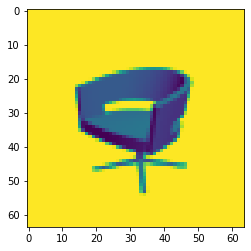

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1024)              193536    
_________________________________________________________________
batch_normalization_13 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_7 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 16384)             16777216  
_________________________________________________________________
batch_normalization_14 (Batc (None, 16384)             65536     
_________________________________________________________________
activation_8 (Activation)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Start epoch: 1
Discriminator loss:0.014043006114661694-------------Auxilliary loss:0.5169044733047485--------------Generator loss:5.47469425201416
Start epoch: 2
Discriminator loss:0.0049054985865950584-------------Auxilliary loss:0.5222238898277283--------------Generator loss:8.790088653564453
Start epoch: 3
Discriminator loss:0.10909072309732437-------------Auxilliary loss:0.2606164813041687--------------Generator loss:6.693971633911133
Start epoch: 4
Discriminator loss:0.01360236294567585-------------Auxilliary loss:0.32933565974235535--------------Generator loss:8.43155574798584
Start epoch: 5
Discriminator loss:0.11829432100057602-------------Auxilliary loss:0.8391520380973816--------------Generator loss:12.429182052612305
Start epoch: 6
Discriminator loss:0.001602332224138081-------------Auxilliary loss:1.8744497299194336--------------Generator loss:13.916688919067383
Start epoch: 7
Discriminator loss:0.004487617406994104-------------Auxilliary loss:0.8124419450759888------------

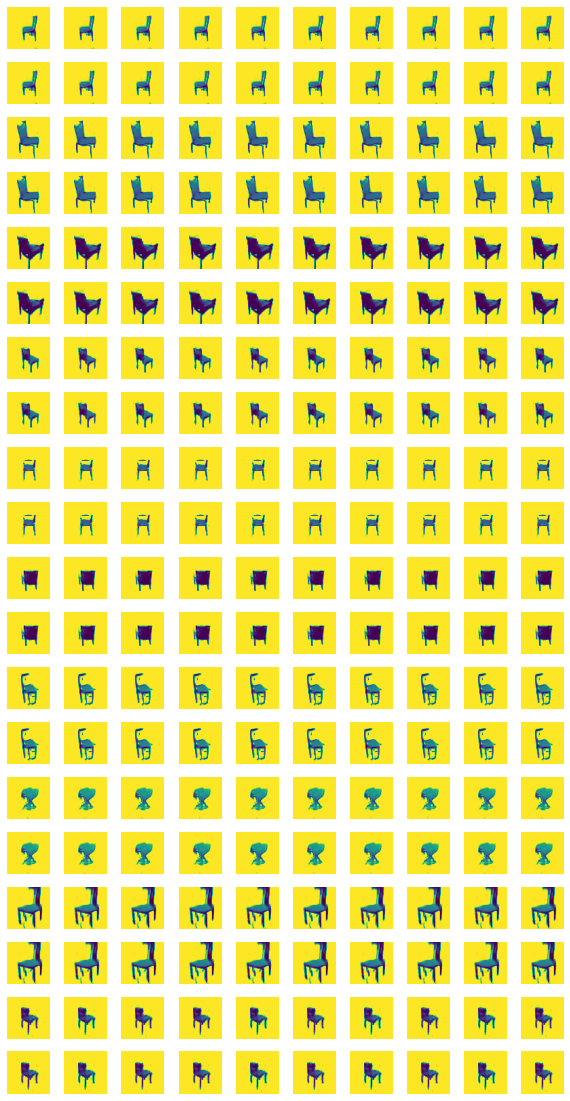

Discriminator loss:0.016947802156209946-------------Auxilliary loss:0.3120635747909546--------------Generator loss:5.969057559967041
Saved checkpoint for step 250: ./gdrive/MyDrive/InfoGAN/chair_infogan_training_checkpoints/ckpt-25
Start epoch: 11
Discriminator loss:0.006529230624437332-------------Auxilliary loss:0.4361567199230194--------------Generator loss:5.874554634094238
Start epoch: 12
Discriminator loss:0.03296921029686928-------------Auxilliary loss:1.066622257232666--------------Generator loss:8.095576286315918
Start epoch: 13
Discriminator loss:0.022351987659931183-------------Auxilliary loss:0.5105466842651367--------------Generator loss:7.803268909454346
Start epoch: 14
Discriminator loss:0.01350845955312252-------------Auxilliary loss:0.38214269280433655--------------Generator loss:9.564533233642578
Start epoch: 15
Discriminator loss:0.043949298560619354-------------Auxilliary loss:0.5850827097892761--------------Generator loss:5.688235759735107
Start epoch: 16
Discrimin

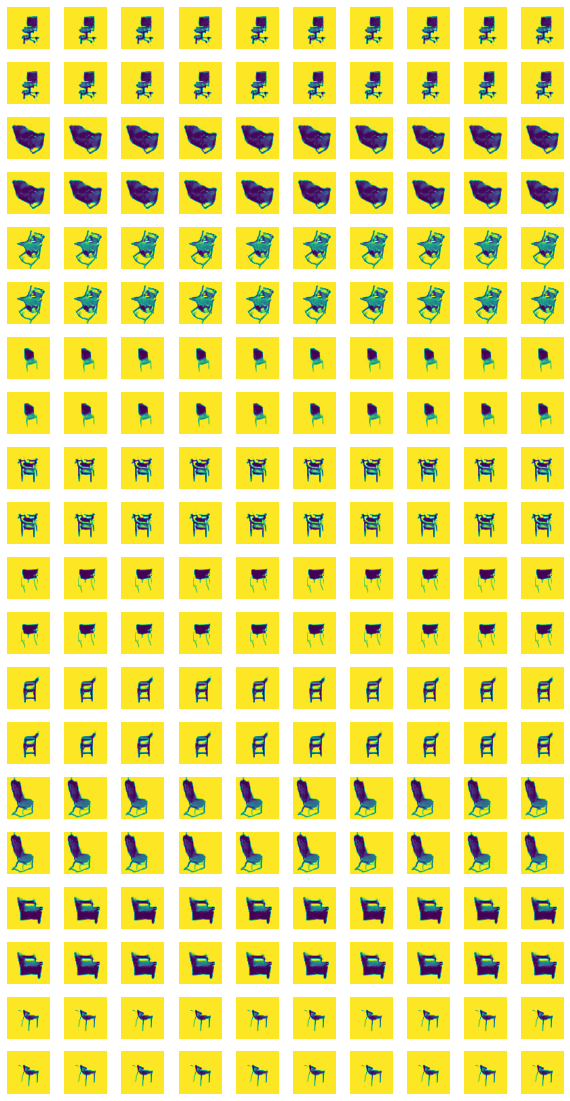

Discriminator loss:0.033573441207408905-------------Auxilliary loss:0.5145150423049927--------------Generator loss:9.47703742980957
Saved checkpoint for step 260: ./gdrive/MyDrive/InfoGAN/chair_infogan_training_checkpoints/ckpt-26



In [ ]:
g_model, d_loss, q_loss, g_loss = training_2()

#plot_loss(d_loss, name="D loss 4", title="Discriminator Loss")

#plot_loss(q_loss, name="Q loss 4", title="Auxilliary Loss")

#plot_loss(g_loss, name="G loss 4", title="Generator Loss")

g_model.save("./gdrive/MyDrive/InfoGAN/chair_infogan_model_4", include_optimizer = True)

#a = [d_loss, q_loss, g_loss]

#a = np.array(a)

#np.savetxt("./gdrive/MyDrive/InfoGAN/chair_loss_3.csv", a, delimiter=",")